In [4]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime
import itertools
import warnings
import sklearn
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Grouper
from matplotlib.pylab import rcParams
from sklearn.model_selection import TimeSeriesSplit
# from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Let's start with some better data 

In separate notebooks, we gathered the EMS, weather, and holiday data and did some initial cleaning steps. Below, we wrangle the data so it's ready for modeling. 

In [6]:
coerced_data = pd.read_csv('../ems_datetime_fixed.csv')

In [7]:
#drop unnecessary columns and ensure time is the index
coerced_data = coerced_data.drop(['Unnamed: 0', 'INCIDENT_DATETIME'], axis=1).set_index('proper_time')
coerced_data.index = pd.to_datetime(coerced_data.index)

One of our goals is to measure the frequency of calls over different time periods, so we need a way to tally calls when we call the "resample" method. Here we'll add a column where we assign a simple value of 1 to every call, and soon we'll use it to tally.

In [8]:
coerced_data['count'] = 1

In [9]:
coerced_data.head()

,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,ZIPCODE,POLICEPRECINCT,STANDBY_INDICATOR,Change_In_Severity,count
proper_time,,,,,,,,,,,,,,,,
2013-01-01 00:00:04,RESPIR,4,RESPIR,4,Y,101,Y,797.0,N,82.0,BRONX,10472.0,43.0,N,0,1
2013-01-01 00:00:19,CARD,3,CARD,3,Y,59,Y,851.0,N,93.0,BRONX,10454.0,40.0,N,0,1
2013-01-01 00:01:04,ARREST,1,ARREST,1,Y,29,Y,429.0,N,83.0,QUEENS,11418.0,102.0,N,0,1
2013-01-01 00:01:16,SICK,6,SICK,6,Y,56,Y,828.0,N,82.0,BRONX,10453.0,46.0,N,0,1
2013-01-01 00:01:26,INJURY,5,INJURY,5,Y,32,Y,856.0,N,82.0,BRONX,10457.0,48.0,N,0,1


Now that the EMS data looks good, let's add in some weather data. 

In [18]:
weather_data = pd.read_csv('../weather_data.csv')

In [19]:
weather_data.set_index('Date', inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

In [20]:
weather_data.head()

,Max Temp,Min Temp,Avg Temp,Precipitation Water Equiv,Snowfall,Snow/Ice Depth
Date,,,,,,
2013-01-01,40,26.0,33.0,0.0,0.0,0.0
2013-01-02,33,22.0,27.5,0.0,0.0,0.0
2013-01-03,32,24.0,28.0,0.0,0.0,0.0
2013-01-04,37,30.0,33.5,0.0,0.0,0.0
2013-01-05,42,32.0,37.0,0.0,0.0,0.0


And let's add in some holiday data. 

In [24]:
holiday_data = pd.read_csv('../holiday_data.csv')

In [25]:
holiday_data.set_index('Date', inplace=True)
holiday_data.index = pd.to_datetime(holiday_data.index)

In [26]:
holiday_data.head()

,Holiday
Date,
2013-01-01,True
2013-01-02,False
2013-01-03,False
2013-01-04,False
2013-01-05,False


Resample all data so we see metrics grouped by week. For EMS data, we want the average response time per week and the total number of calls per week. For the weather data, we want the average weekly temperature, as well as the total rainfall and snowfall per week. Lastly, for the holiday data, we want the total number of holidays per week. 

In [27]:
weekly_call_volume = coerced_data['count'].resample('W').sum()
weekly_average_response_time = coerced_data['INCIDENT_RESPONSE_SECONDS_QY'].resample('W').mean()

#modify our avearge response time data to measure time in minutes instead of seconds
weekly_average_response_time = weekly_average_response_time / 60

In [28]:
weekly_average_temperature_data = pd.DataFrame(weather_data['Avg Temp'].resample('W').mean())
weekly_sum_precipitation = pd.DataFrame(weather_data['Precipitation Water Equiv'].resample('W').sum())
weekly_sum_snowfall = pd.DataFrame(weather_data['Snowfall'].resample('W').sum())

In [29]:
weekly_sum_holidays = holiday_data.resample('W').sum()

Create a DataFrame to merge average response time data with holiday and weather data.

In [30]:
weekly_average_response_time_df = pd.DataFrame(data=weekly_average_response_time, index=weekly_average_response_time.index)

weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, weekly_average_temperature_data, left_index=True, right_index=True)

weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, weekly_sum_precipitation, left_index=True, right_index=True)

weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, weekly_sum_snowfall, left_index=True, right_index=True)

weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, weekly_sum_holidays, left_index=True, right_index=True)

#rename the columns so they are easier to understand and reference
weekly_average_response_time_df.columns = ['avg_response_time_min', 'avg_temp', 'total_precip', 'total_snowfall', 'total_holidays']

In [31]:
weekly_average_response_time_df.head()

,avg_response_time_min,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2013-01-06,11.203026,33.166667,0.0001,0.001,1.0
2013-01-13,11.848662,43.214286,0.5700,0.000,0.0
2013-01-20,9.846154,38.428571,0.9000,0.001,0.0
2013-01-27,8.906825,21.071429,0.0701,1.501,1.0
2013-02-03,9.237061,35.428571,1.2600,0.401,0.0


Create a DataFrame to merge average call volume data with holiday and weather data.

In [32]:
weekly_call_volume_df = pd.DataFrame(data=weekly_call_volume, index=weekly_call_volume.index)
weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_average_temperature_data, left_index=True, right_index=True)
weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_sum_precipitation, left_index=True, right_index=True)
weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_sum_snowfall, left_index=True, right_index=True)
weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_sum_holidays, left_index=True, right_index=True)

#rename the columns so they are easier to understand and reference
weekly_call_volume_df.columns = ['sum of weekly calls', 'avg_temp', 'total_precip', 'total_snowfall', 'total_holidays']

In [33]:
weekly_call_volume_df.head()

,sum of weekly calls,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2013-01-06,23449,33.166667,0.0001,0.001,1.0
2013-01-13,27193,43.214286,0.5700,0.000,0.0
2013-01-20,25044,38.428571,0.9000,0.001,0.0
2013-01-27,23313,21.071429,0.0701,1.501,1.0
2013-02-03,24656,35.428571,1.2600,0.401,0.0


## EDA and Stationarity Check 

We wanted to see if there were any noticeable trends, so we explored the data through visualizations. Additionally, stationarity is a key assumption for time series models, so we used the Dickey-Fuller test statistic to test for stationarity. 

### Dickey-Fuller Tests:

In [34]:
#create function to perform Dickey-Fuller test and print key statistics
def dickey_fuller(ser):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ser.values)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return None

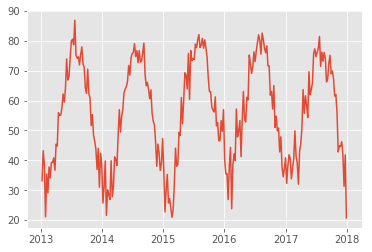

Results of Dickey-Fuller Test:
Test Statistic                -7.373287e+00
p-value                        8.855958e-11
#Lags Used                     1.600000e+01
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


In [35]:
#EDA and Dickey-Fuller for weekly average temperature 
plt.plot(weekly_average_response_time_df['avg_temp'])
plt.show()
dickey_fuller(weekly_average_response_time_df['avg_temp'])

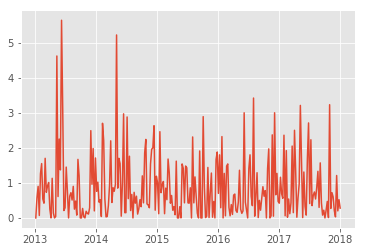

Results of Dickey-Fuller Test:
Test Statistic                -1.654803e+01
p-value                        1.956570e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.600000e+02
Critical Value (1%)           -3.455754e+00
Critical Value (5%)           -2.872721e+00
Critical Value (10%)          -2.572728e+00
dtype: float64


In [36]:
#EDA and Dickey-Fuller for total weekly precipitation  
plt.plot(weekly_average_response_time_df['total_precip'])
plt.show()
dickey_fuller(weekly_average_response_time_df['total_precip'])

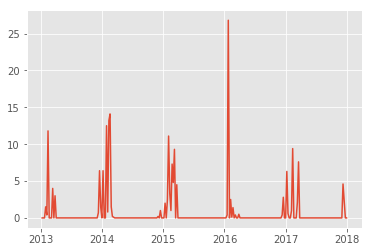

Results of Dickey-Fuller Test:
Test Statistic                -6.801037e+00
p-value                        2.236803e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.580000e+02
Critical Value (1%)           -3.455953e+00
Critical Value (5%)           -2.872809e+00
Critical Value (10%)          -2.572775e+00
dtype: float64


In [37]:
#EDA and Dickey-Fuller for total weekly snowfall  
plt.plot(weekly_average_response_time_df['total_snowfall'])
plt.show()
dickey_fuller(weekly_average_response_time_df['total_snowfall'])

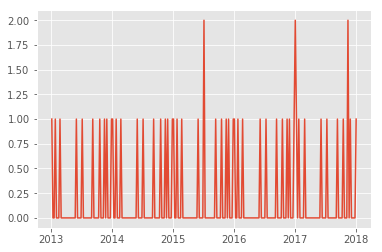

Results of Dickey-Fuller Test:
Test Statistic                  -4.678656
p-value                          0.000092
#Lags Used                      13.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


In [38]:
#EDA and Dickey-Fuller for total number of holidays in a week 
plt.plot(weekly_average_response_time_df['total_holidays'])
plt.show()
dickey_fuller(weekly_average_response_time_df['total_holidays'])

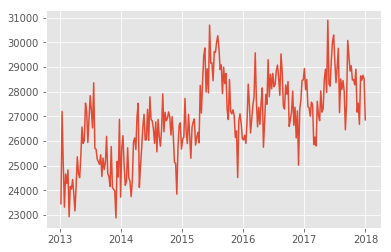

Results of Dickey-Fuller Test:
Test Statistic                  -2.774700
p-value                          0.061980
#Lags Used                       3.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64


In [39]:
#EDA and Dickey-Fuller for total number of calls in a week 
plt.plot(weekly_call_volume)
plt.show()
dickey_fuller(weekly_call_volume)

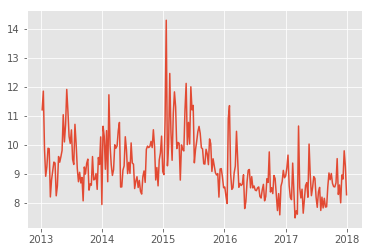

Results of Dickey-Fuller Test:
Test Statistic                  -3.759599
p-value                          0.003349
#Lags Used                       3.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64


In [40]:
#EDA and Dickey-Fuller for weekly average response time 
plt.plot(weekly_average_response_time)
plt.show()
dickey_fuller(weekly_average_response_time)

At first glance, we get a decent P-val for our stationarity check on the total number of calls in a week and the weekly average response time, but we know we can do better. There must be seasonality to our data.

### Seasonality and Trends

EMS Response time:

<Figure size 432x288 with 0 Axes>

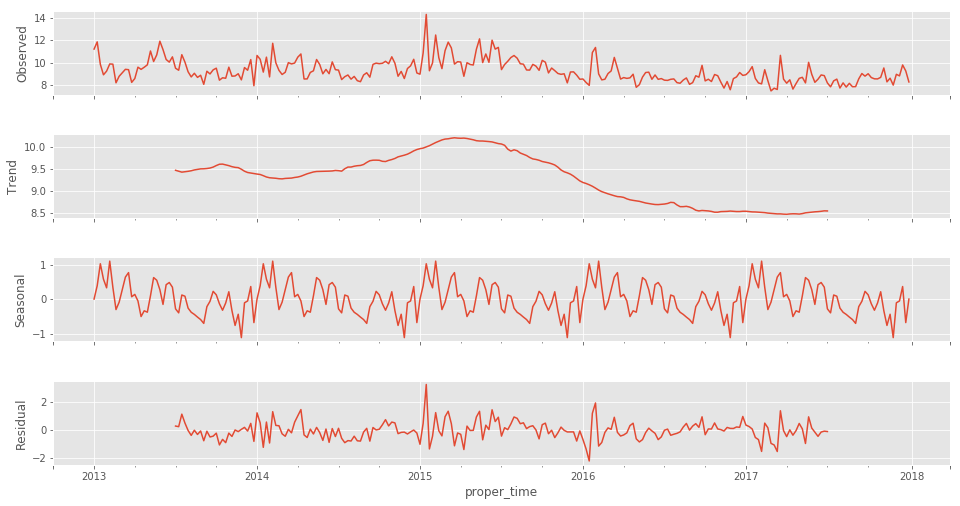

In [41]:
#seasonal decomposition for weekly average response time 
decomposition = seasonal_decompose(weekly_average_response_time, freq=52)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

Call Volume:

<Figure size 432x288 with 0 Axes>

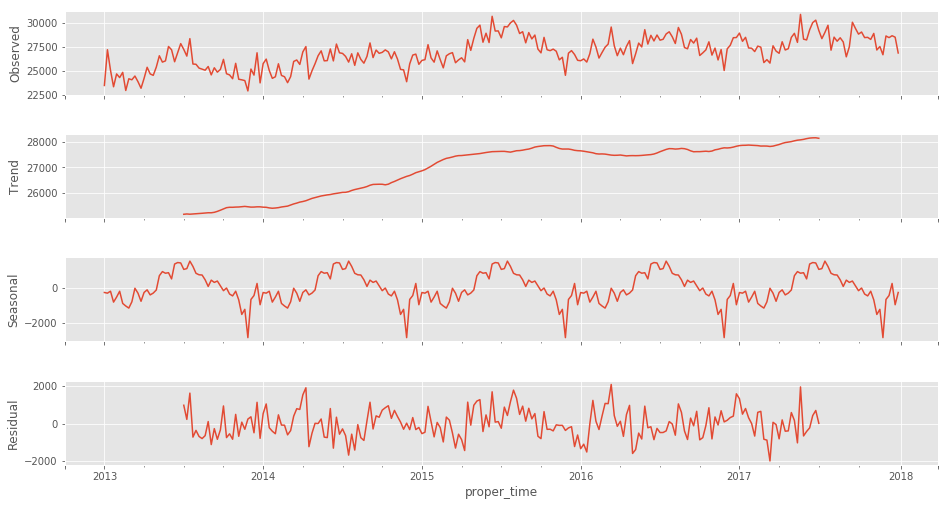

In [42]:
#seasonal decomposition for total number of calls in a week 
decomposition = seasonal_decompose(weekly_call_volume, freq=52)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

### Seasonal First-Differencing:

EMS Response Time:

In [43]:
#for average response time, found seasonal first difference to produce best results
response_time_first_diff = weekly_average_response_time - weekly_average_response_time.shift(1)
response_time_seasonal_first_difference = (response_time_first_diff - response_time_first_diff.shift(52)).dropna()
dickey_fuller(response_time_seasonal_first_difference)

Results of Dickey-Fuller Test:
Test Statistic                -1.025001e+01
p-value                        4.511493e-18
#Lags Used                     5.000000e+00
Number of Observations Used    2.020000e+02
Critical Value (1%)           -3.463144e+00
Critical Value (5%)           -2.875957e+00
Critical Value (10%)          -2.574455e+00
dtype: float64


EMS Call Volume:

In [44]:
#for call volume, found seasonal first difference to produce best results
call_volume_first_diff = weekly_call_volume - weekly_call_volume.shift(1)
call_volume_seasonal_first_difference = (call_volume_first_diff - call_volume_first_diff.shift(52)).dropna()
dickey_fuller(call_volume_seasonal_first_difference)

Results of Dickey-Fuller Test:
Test Statistic                -6.390973e+00
p-value                        2.106404e-08
#Lags Used                     1.100000e+01
Number of Observations Used    1.960000e+02
Critical Value (1%)           -3.464161e+00
Critical Value (5%)           -2.876402e+00
Critical Value (10%)          -2.574692e+00
dtype: float64


### Autocorrelation and Partial Autocorrelation:

EMS Response time:

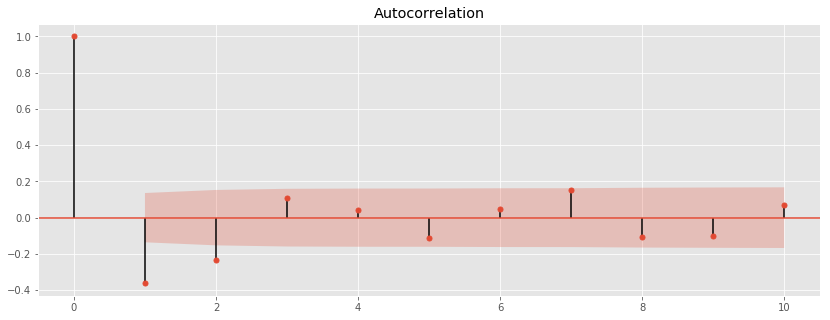

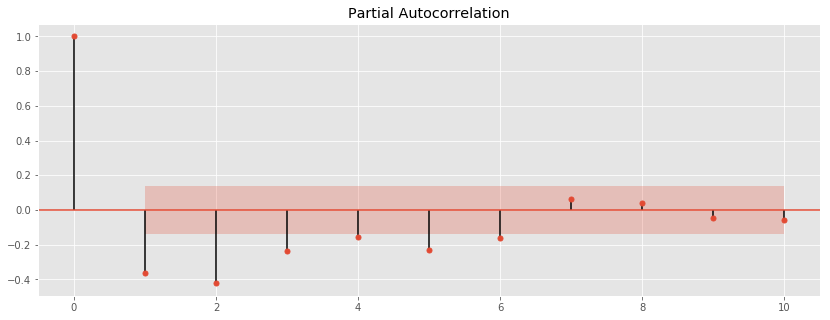

In [45]:
#ACF and PCF for average response time 
rcParams['figure.figsize'] = 14, 5
plot_acf(response_time_seasonal_first_difference, lags = 10);

rcParams['figure.figsize'] = 14, 5
plot_pacf(response_time_seasonal_first_difference, lags = 10);

Call Volume:

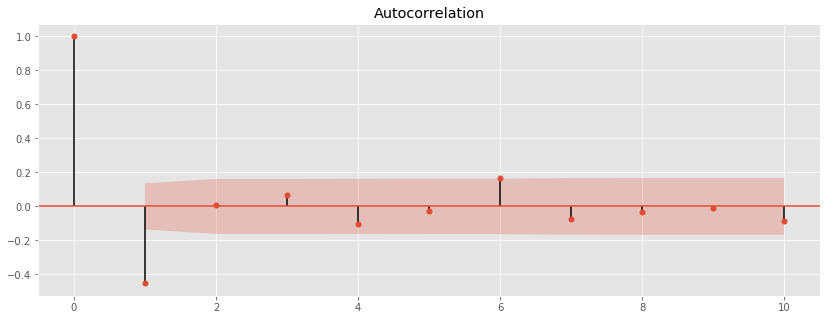

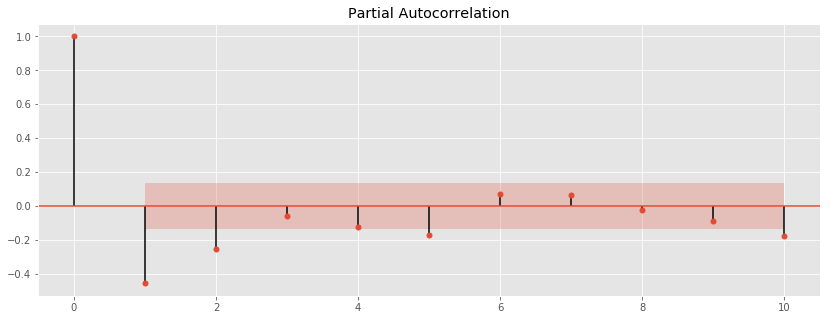

In [46]:
#ACF and PCF for call volume
rcParams['figure.figsize'] = 14, 5
plot_acf(call_volume_seasonal_first_difference, lags = 10);

rcParams['figure.figsize'] = 14, 5
plot_pacf(call_volume_seasonal_first_difference, lags = 10);

## Time to Model Average Response Time

Grid search for ideal parameters.

In [47]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [48]:
def arima_gs(ts):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue

    # Find the parameters with minimal AIC value.

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    print(ans_df)
    print(ans_df.loc[ans_df['aic'].idxmin()])

In [49]:
# arima_gs(weekly_average_response_time)

We decided to split our data into training and test sets with an 80-20 split.

In [50]:
endogenous_train = weekly_average_response_time[:-52]
exogenous_train = weekly_average_response_time_df.drop(['avg_response_time_min'], axis=1)[:-52]
endogenous_test = weekly_average_response_time[-52:]
exogenous_test = weekly_average_response_time_df.drop(['avg_response_time_min'], axis=1)[-52:]

Fit training data on SARIMAX model with optimal parameters.

In [51]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(endogenous_train,
                                exog = exogenous_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp           0.0112         -0       -inf      0.000       0.011       0.011
total_precip       0.1621         -0       -inf      0.000       0.162       0.162
total_snowfall     0.0688   2.54e-38    2.7e+36      0.000       0.069       0.069
total_holidays     0.1355      3e-38   4.51e+36      0.000       0.135       0.135
ar.L1              0.8762   2.44e-35   3.59e+34      0.000       0.876       0.876
ma.L1             -0.4783   3.47e-35  -1.38e+34      0.000      -0.478      -0.478
ma.S.L52       -1.279e+15   2.77e-34  -4.61e+48      0.000   -1.28e+15   -1.28e+15
sigma2          3.231e-13   1.87e-10      0.002      0.999   -3.66e-10    3.67e-10


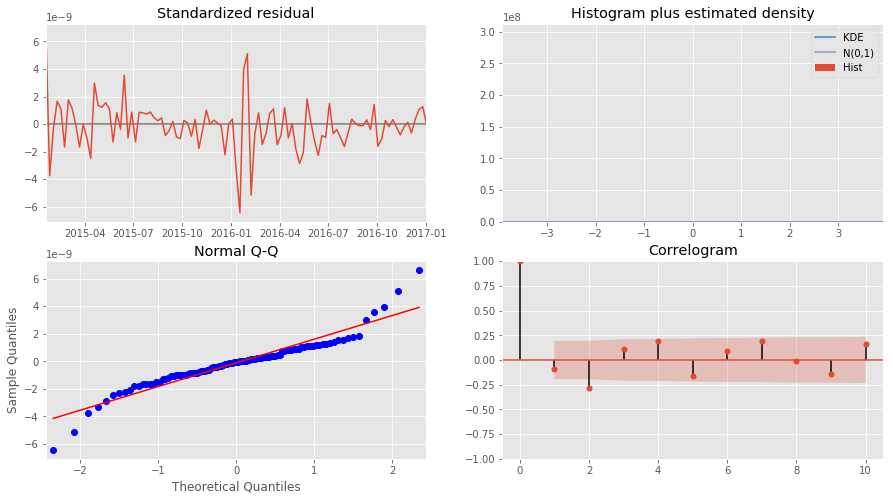

In [52]:
output.plot_diagnostics(figsize=(15, 8))
plt.show()

Generate predictions.

In [53]:
prediction = output.get_prediction(start = endogenous_test.index[0],
                                    end = endogenous_test.index[-1],
                                    exog = exogenous_test,
                                    dynamic = False)

pred_conf = prediction.conf_int()

Let's see what our predictions look like against actual values. 

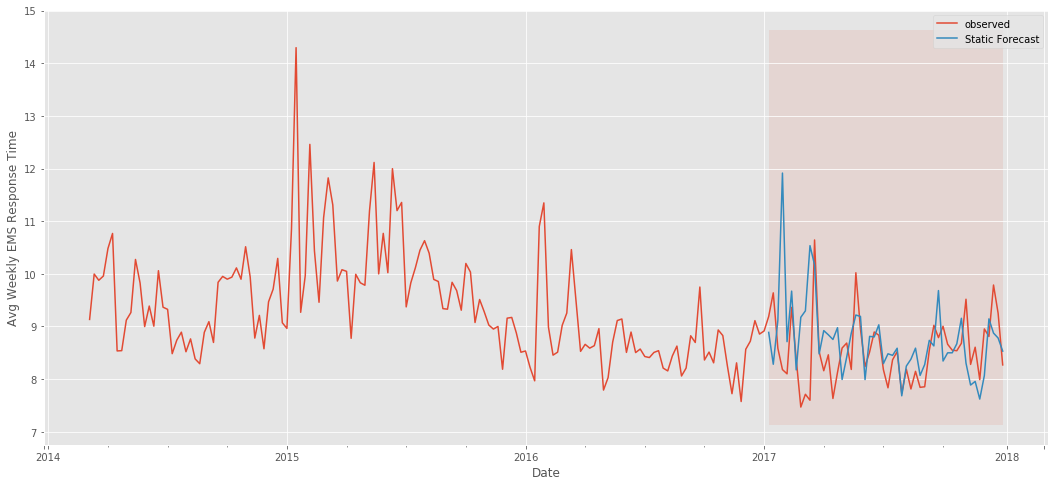

In [54]:
# Plot the static forecast with confidence intervals.

ax = weekly_average_response_time[-200:].plot(label='observed', figsize=(18, 8))
prediction.predicted_mean.plot(label='Static Forecast', ax=ax)

# ax.fill_between(pred_conf.index,
#                 pred_conf.iloc[:, 0],
#                 pred_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 weekly_average_response_time[-52:-50].index[0], 
                 '2017-12-31', 
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Weekly EMS Response Time')

plt.legend()
plt.show()

Let's define some error metrics. 

In [55]:
response_time_mean = np.zeros((len(weekly_average_response_time),1))
response_time_mean.fill(np.mean(weekly_average_response_time[:-52]))
response_time_mean = pd.DataFrame(response_time_mean, 
                                      index=weekly_average_response_time.index)

baseline_mse = np.mean((response_time_mean[-52:][0] - endogenous_test)**2)
baseline_rmse = np.sqrt(baseline_mse)
print('The MSE when guessing the mean is {}'.format(baseline_mse))
print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

The MSE when guessing the mean is 1.1930240270839332
The RMSE when guessing the mean is 1.0922563925580537


In [56]:
mse = ((prediction.predicted_mean - endogenous_test)**2).mean()
rmse = np.sqrt(mse)
print('The MSE for this model is {}'.format(mse))
print('The RMSE for this model is {}'.format(rmse))

print(f'''Our model does {np.round(((baseline_rmse - rmse) / baseline_rmse * 100), 
                                    decimals=2)}% better than guessing the mean response time!''')

The MSE for this model is 0.8180191200198077
The RMSE for this model is 0.904444094468977
Our model does 17.19% better than guessing the mean response time!


## Now we'll do the same for Call Volume

In [57]:
endogenous_train = weekly_call_volume[:-52]
exogenous_train = weekly_call_volume_df.drop(['sum of weekly calls'], axis=1)[:-52]
endogenous_test = weekly_call_volume[-52:]
exogenous_test = weekly_call_volume_df.drop(['sum of weekly calls'], axis=1)[-52:]

In [58]:
# arima_gs(weekly_call_volume)

Our grid search actually returned the same parameters for call volume that it did for response times, unsurprisingly. These are pretty much colinear endogenous variables.

In [59]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(endogenous_train,
                                exog = exogenous_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp          86.6069         -0       -inf      0.000      86.607      86.607
total_precip     -29.8947         -0        inf      0.000     -29.895     -29.895
total_snowfall    37.3603   1.92e-37   1.95e+38      0.000      37.360      37.360
total_holidays   230.0114   2.91e-37   7.91e+38      0.000     230.011     230.011
ar.L1              0.9385   7.64e-35   1.23e+34      0.000       0.938       0.938
ma.L1             -0.4361   2.49e-34  -1.75e+33      0.000      -0.436      -0.436
ma.S.L52       -7.051e+14   8.34e-33  -8.45e+46      0.000   -7.05e+14   -7.05e+14
sigma2          3.669e-09   7.61e-10      4.820      0.000    2.18e-09    5.16e-09


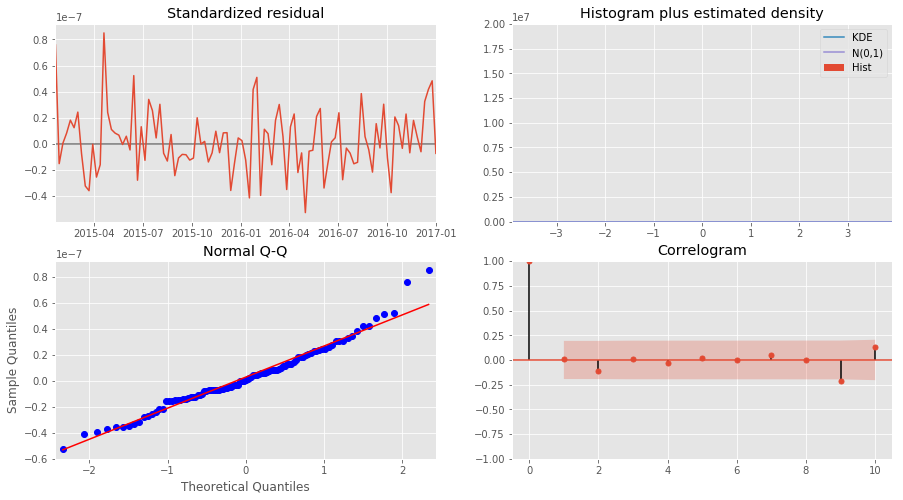

In [60]:
output.plot_diagnostics(figsize=(15, 8))
plt.show()

In [61]:
prediction = output.get_prediction(start = endogenous_test.index[0],
                                    end = endogenous_test.index[-1],
                                    exog = exogenous_test,
                                    dynamic = False)

pred_conf = prediction.conf_int()

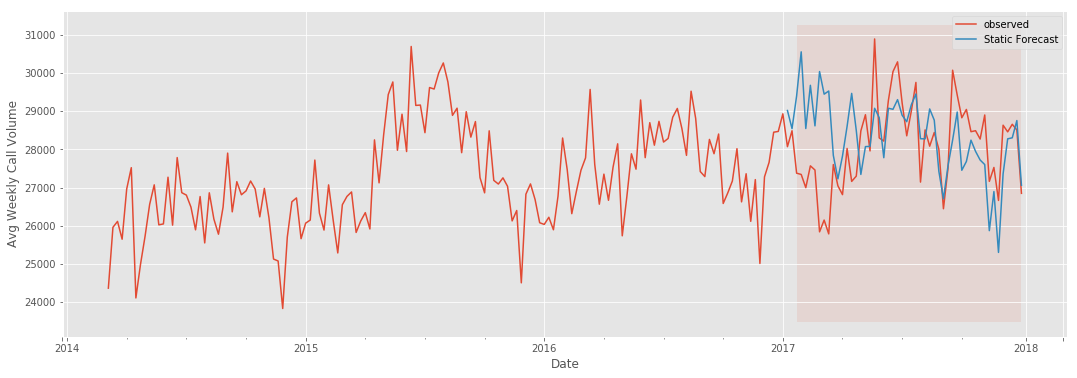

In [62]:
# Plot the static forecast with confidence intervals.

ax = weekly_call_volume[-200:].plot(label='observed', figsize=(18, 6))
prediction.predicted_mean.plot(label='Static Forecast', ax=ax)

# ax.fill_between(pred_conf.index,
#                 pred_conf.iloc[:, 0],
#                 pred_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 weekly_average_response_time[-50:-49].index[0], 
                 '2017-12-31', 
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Weekly Call Volume')

plt.legend()
plt.show()

In [63]:
call_vol_mean = np.zeros((len(weekly_call_volume),1))
call_vol_mean.fill(np.mean(weekly_call_volume[:-52]))
call_vol_mean = pd.DataFrame(call_vol_mean, 
                                      index=weekly_call_volume.index)

In [64]:
baseline_mse = np.mean((call_vol_mean[-52:][0] - endogenous_test)**2)
baseline_rmse = np.sqrt(baseline_mse)
print('The MSE when guessing the mean is {}'.format(baseline_mse))
print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

The MSE when guessing the mean is 3483004.8492078898
The RMSE when guessing the mean is 1866.2810209633194


In [65]:
mse = ((prediction.predicted_mean - endogenous_test)**2).mean()
rmse = np.sqrt(mse)
print('The MSE for this model is {}'.format(mse))
print('The RMSE for this model is {}'.format(rmse))

The MSE for this model is 1928712.2918200283
The RMSE for this model is 1388.78086529878


In [66]:
print(f'''Our model does {np.round(((baseline_rmse - rmse) / baseline_rmse * 100), 
                                    decimals=2)}% better than guessing the mean call volume!''')

Our model does 25.59% better than guessing the mean call volume!


In [67]:
print(f'Our model is off by about {np.round((rmse/7),2)} calls per day on average.')
print(f'There are usually around {np.round((26908.908046/7),2)} calls per day.')

Our model is off by about 198.4 calls per day on average.
There are usually around 3844.13 calls per day.


## Vs. The Facebook's "Prophet"

In [68]:
df = pd.DataFrame(weekly_average_response_time[:-52]) # Formatting a DF how Prophet likes it
df.columns = ['y']
df['ds'] = df.index
m = Prophet(weekly_seasonality=True, daily_seasonality=True)
m.fit(df)

NameError: name 'Prophet' is not defined

In [ ]:
future = m.make_future_dataframe(periods=52, freq='W')
forecast = m.predict(future)

In [ ]:
forecast.index = pd.date_range(start=df.index[0], periods=len(forecast), freq='W')

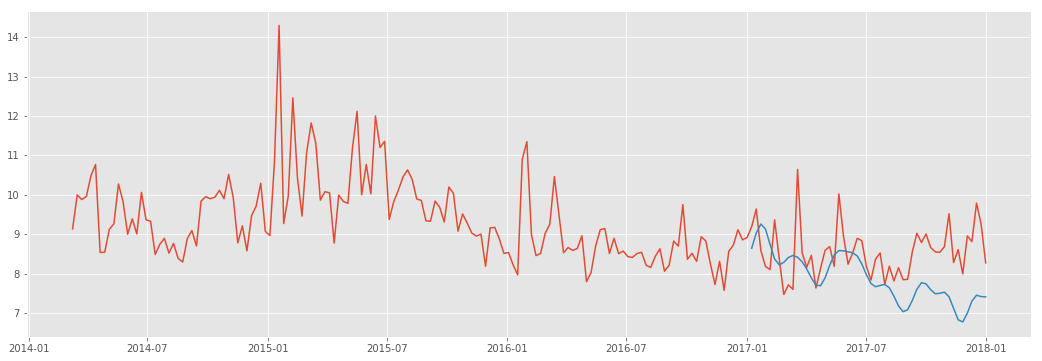

In [119]:
plt.figure(figsize=(18,6))
plt.plot(weekly_average_response_time[-200:])
plt.plot(forecast['yhat'][-52:])
plt.show()

Error Metrics!

In [120]:
response_time_mean = np.zeros((len(weekly_average_response_time),1))
response_time_mean.fill(np.mean(weekly_average_response_time[:-52]))
response_time_mean = pd.DataFrame(response_time_mean, 
                                      index=weekly_average_response_time.index)

baseline_mse = np.mean((response_time_mean[-52:][0] - endogenous_test)**2)
baseline_rmse = np.sqrt(baseline_mse)
print('The MSE when guessing the mean is {}'.format(baseline_mse))
print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

The MSE when guessing the mean is 791093916.5552151
The RMSE when guessing the mean is 28126.391815432264


In [121]:
mse = ((forecast['yhat'][-52:] - endogenous_test)**2).mean()
rmse = np.sqrt(mse)
print('The MSE for this model is {}'.format(mse))
print('The RMSE for this model is {} \n'.format(rmse))

print(f'''This model does {np.round(((baseline_rmse - rmse) / baseline_rmse * 100), 
                                    decimals=2)}% better than guessing the mean response time! Not so good.''')

The MSE for this model is 791180403.5805529
The RMSE for this model is 28127.929244445866 

This model does -0.01% better than guessing the mean response time! Not so good.


## Let's explore the data more 

In [ ]:
weekly_call_volume_df.describe()

In [ ]:
weekly_average_response_time_df.describe()

In [ ]:
weekly_average_response_time_df.nlargest(10, 'avg_response_time_min')

In [ ]:
weekly_average_response_time_df.nsmallest(10, 'avg_response_time_min')

In [ ]:
weekly_call_volume_df.nlargest(10, 'sum of weekly calls')

In [ ]:
weekly_call_volume_df.nsmallest(10, 'sum of weekly calls')

## Let's split it all up by borough 

In [222]:
def arima_gs(ts):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue

    # Find the parameters with minimal AIC value.

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    print(ans_df)
    print(ans_df.loc[ans_df['aic'].idxmin()])

In [223]:
arima_gs(weekly_average_response_time)

ARIMA (0, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =1899.6568919874746
ARIMA (0, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =1355.2659275162491
ARIMA (0, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =725.4797962187847
ARIMA (0, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =510.18390318397115
ARIMA (0, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =718.0288127888143
ARIMA (0, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =630.7199203061649
ARIMA (0, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =531.5390429190197
ARIMA (0, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =525.7958872687234
ARIMA (0, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =1571.571426178552
ARIMA (0, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =1122.4585773148274
ARIMA (0, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =681.1327079051259
ARIMA (0, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =460.8704992791606
ARIMA (0, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =678.6224672930571
ARIMA (0, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =679.3139764580699
ARIMA (0, 0, 1) 

In [209]:
def avg_time_by_borough(borough_name):
    
    print('The average response time model results for {} are below'.format(borough_name))
    borough_data = coerced_data[coerced_data['BOROUGH'] == borough_name]
    borough_data['count'] = 1

    #regroup data by week 
    borough_call_volume = borough_data['count'].resample('W').sum()
    borough_average_response_time = borough_data['INCIDENT_RESPONSE_SECONDS_QY'].resample('W').mean()

    #modify our avearge response time data to measure time in minutes instead of seconds
    borough_average_response_time = borough_average_response_time / 60

    borough_average_response_time_df = pd.DataFrame(data=borough_average_response_time, index=borough_call_volume.index)
    borough_average_response_time_df = pd.merge(borough_average_response_time_df, weekly_average_temperature_data, left_index=True, right_index=True)
    borough_average_response_time_df = pd.merge(borough_average_response_time_df, weekly_sum_precipitation, left_index=True, right_index=True)
    borough_average_response_time_df = pd.merge(borough_average_response_time_df, weekly_sum_snowfall, left_index=True, right_index=True)
    borough_average_response_time_df = pd.merge(borough_average_response_time_df, weekly_sum_holidays, left_index=True, right_index=True)

    #rename the columns so they are easier to understand and reference
    borough_average_response_time_df.columns = ['avg_response_time_min', 'avg_temp', 'total_precip', 'total_snowfall', 'total_holidays']

    endogenous_train = borough_average_response_time[:-52]
    exogenous_train = borough_average_response_time_df.drop(['avg_response_time_min'], axis=1)[:-52]
    endogenous_test = borough_average_response_time[-52:]
    exogenous_test = borough_average_response_time_df.drop(['avg_response_time_min'], axis=1)[-52:]

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(endogenous_train,
                                    exog = exogenous_train,
                                    order=(1, 0, 1),
                                    seasonal_order=(0, 1, 1, 52),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    output = ARIMA_MODEL.fit()

    print(output.summary().tables[1])

    output.plot_diagnostics(figsize=(15, 8))
    plt.show()

    prediction = output.get_prediction(start = endogenous_test.index[0],
                                        end = endogenous_test.index[-1],
                                        exog = exogenous_test,
                                        dynamic = False)

    pred_conf = prediction.conf_int()

    # Plot the static forecast with confidence intervals.

    ax = borough_average_response_time[-200:].plot(label='observed', figsize=(18, 6))
    prediction.predicted_mean.plot(label='Static Forecast', ax=ax)

    # ax.fill_between(pred_conf.index,
    #                 pred_conf.iloc[:, 0],
    #                 pred_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), 
                     borough_average_response_time[-50:-49].index[0], 
                     '2017-12-31', 
                     alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Avg Response Time')

    plt.legend()
    plt.show()

    response_time_mean = np.zeros((len(borough_average_response_time),1))
    response_time_mean.fill(np.mean(borough_average_response_time[:-52]))
    response_time_mean = pd.DataFrame(response_time_mean, 
                                          index=borough_average_response_time.index)

    baseline_mse = np.mean((response_time_mean[-52:][0] - endogenous_test)**2)
    baseline_rmse = np.sqrt(baseline_mse)
    print('The MSE when guessing the mean is {}'.format(baseline_mse))
    print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

    mse = ((prediction.predicted_mean - endogenous_test)**2).mean()
    rmse = np.sqrt(mse)
    print('The MSE for this model is {}'.format(mse))
    print('The RMSE for this model is {}'.format(rmse))

    print(f'''Our model does {np.round(((baseline_rmse - rmse) / baseline_rmse * 100), 
                                        decimals=2)}% better than guessing the mean call volume!''')

In [212]:
def volume_by_borough(borough_name):
    print('The call volume model results for {} are below'.format(borough_name))
    
    borough_data = coerced_data[coerced_data['BOROUGH'] == borough_name]
    borough_data['count'] = 1

    #regroup data by week 
    borough_call_volume = borough_data['count'].resample('W').sum()
    borough_average_response_time = borough_data['count'].resample('W').mean()

    #modify our avearge response time data to measure time in minutes instead of seconds
    borough_average_response_time = borough_average_response_time / 60
    
    borough_call_volume_df = pd.DataFrame(data=borough_call_volume, index=borough_call_volume.index)
    borough_call_volume_df = pd.merge(borough_call_volume_df, weekly_average_temperature_data, left_index=True, right_index=True)
    borough_call_volume_df = pd.merge(borough_call_volume_df, weekly_sum_precipitation, left_index=True, right_index=True)
    borough_call_volume_df = pd.merge(borough_call_volume_df, weekly_sum_snowfall, left_index=True, right_index=True)
    borough_call_volume_df = pd.merge(borough_call_volume_df, weekly_sum_holidays, left_index=True, right_index=True)

    #rename the columns so they are easier to understand and reference
    borough_call_volume_df.columns = ['sum of weekly calls', 'avg_temp', 'total_precip', 'total_snowfall', 'total_holidays']

    endogenous_train = borough_call_volume[:-52]
    exogenous_train = borough_call_volume_df.drop(['sum of weekly calls'], axis=1)[:-52]
    endogenous_test = borough_call_volume[-52:]
    exogenous_test = borough_call_volume_df.drop(['sum of weekly calls'], axis=1)[-52:]

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(endogenous_train,
                                    exog = exogenous_train,
                                    order=(1, 0, 1),
                                    seasonal_order=(0, 1, 1, 52),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    output = ARIMA_MODEL.fit()

    print(output.summary().tables[1])

    output.plot_diagnostics(figsize=(15, 8))
    plt.show()

    prediction = output.get_prediction(start = endogenous_test.index[0],
                                        end = endogenous_test.index[-1],
                                        exog = exogenous_test,
                                        dynamic = False)

    pred_conf = prediction.conf_int()

    # Plot the static forecast with confidence intervals.

    ax = borough_call_volume[-200:].plot(label='observed', figsize=(18, 6))
    prediction.predicted_mean.plot(label='Static Forecast', ax=ax)

    # ax.fill_between(pred_conf.index,
    #                 pred_conf.iloc[:, 0],
    #                 pred_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), 
                     borough_call_volume[-50:-49].index[0], 
                     '2017-12-31', 
                     alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Call Volume')

    plt.legend()
    plt.show()

    call_volume_mean = np.zeros((len(borough_call_volume),1))
    call_volume_mean.fill(np.mean(borough_call_volume[:-52]))
    call_volume_mean = pd.DataFrame(call_volume_mean, 
                                          index=borough_call_volume.index)

    baseline_mse = np.mean((call_volume_mean[-52:][0] - endogenous_test)**2)
    baseline_rmse = np.sqrt(baseline_mse)
    print('The MSE when guessing the mean is {}'.format(baseline_mse))
    print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

    mse = ((prediction.predicted_mean - endogenous_test)**2).mean()
    rmse = np.sqrt(mse)
    print('The MSE for this model is {}'.format(mse))
    print('The RMSE for this model is {}'.format(rmse))

    print(f'''Our model does {np.round(((baseline_rmse - rmse) / baseline_rmse * 100), 
                                        decimals=2)}% better than guessing the mean call volume!''')

###### The Bronx

The average response time model results for BRONX are below
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp          -0.0233         -0        inf      0.000      -0.023      -0.023
total_precip       0.2883         -0       -inf      0.000       0.288       0.288
total_snowfall     0.0797   4.08e-36   1.96e+34      0.000       0.080       0.080
total_holidays     0.9213    1.3e-36   7.11e+35      0.000       0.921       0.921
ar.L1              0.9716   1.29e-35   7.52e+34      0.000       0.972       0.972
ma.L1             -0.6127   6.56e-35  -9.34e+33      0.000      -0.613      -0.613
ma.S.L52       -2.166e+14   1.64e-33  -1.32e+47      0.000   -2.17e+14   -2.17e+14
sigma2          5.812e-13   1.87e-10      0.003      0.998   -3.66e-10    3.67e-10


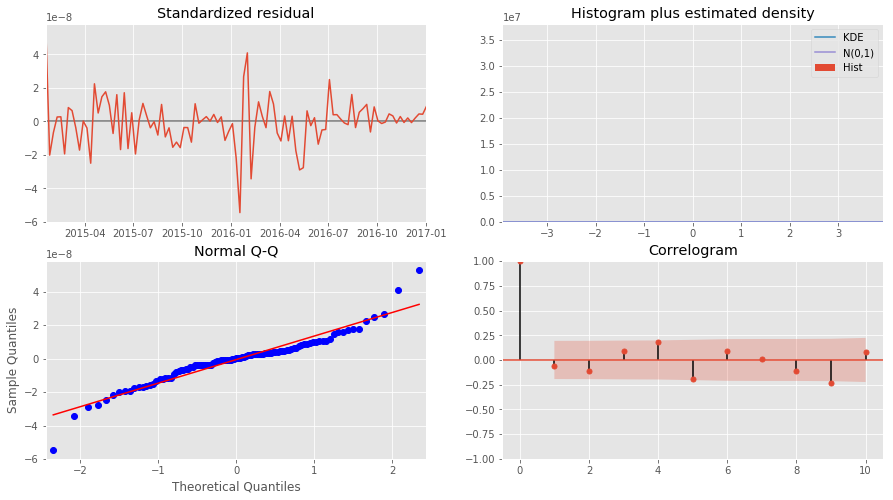

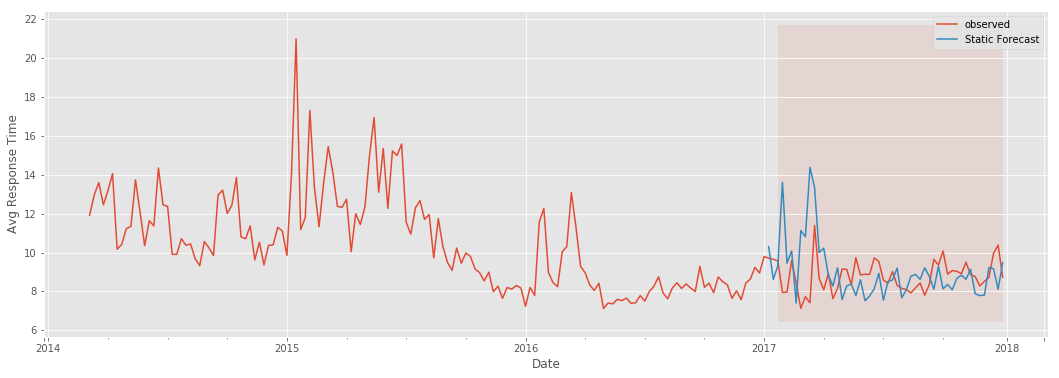

The MSE when guessing the mean is 3.647605569295673
The RMSE when guessing the mean is 1.9098705634926343
The MSE for this model is 3.042311459727299
The RMSE for this model is 1.7442223080007029
Our model does 8.67% better than guessing the mean call volume!


In [210]:
avg_time_by_borough('BRONX')

The call volume model results for BRONX are below
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp          20.3564         -0       -inf      0.000      20.356      20.356
total_precip       7.7086         -0       -inf      0.000       7.709       7.709
total_snowfall     7.7828   5.99e-37    1.3e+37      0.000       7.783       7.783
total_holidays    97.0698   1.98e-37   4.91e+38      0.000      97.070      97.070
ar.L1              0.9347   2.72e-34   3.43e+33      0.000       0.935       0.935
ma.L1             -0.4311   5.87e-34  -7.35e+32      0.000      -0.431      -0.431
ma.S.L52       -4.081e+14   1.05e-32  -3.89e+46      0.000   -4.08e+14   -4.08e+14
sigma2           3.07e-09    6.5e-10      4.724      0.000     1.8e-09    4.34e-09


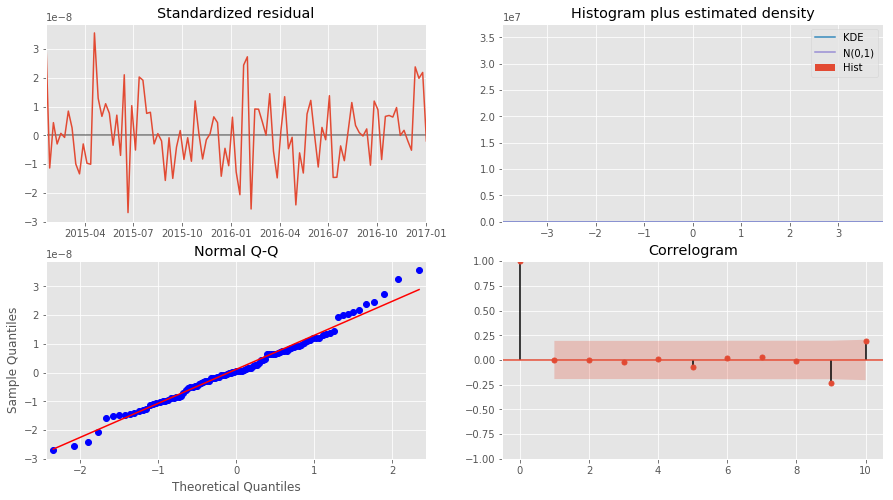

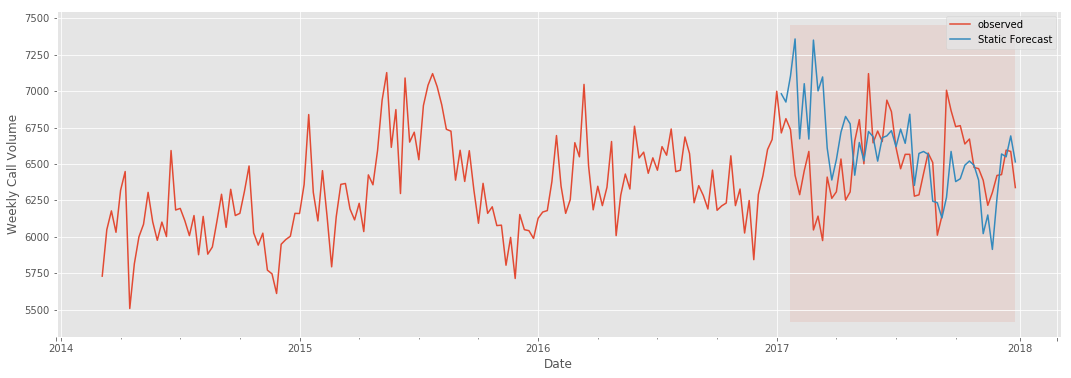

The MSE when guessing the mean is 187816.04174848038
The RMSE when guessing the mean is 433.3774818198107
The MSE for this model is 155036.9028379638
The RMSE for this model is 393.7472575624671
Our model does 9.14% better than guessing the mean call volume!


In [213]:
volume_by_borough('BRONX')

###### Brooklyn

The average response time model results for BROOKLYN are below
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp           0.0073         -0       -inf      0.000       0.007       0.007
total_precip       0.1064         -0       -inf      0.000       0.106       0.106
total_snowfall     0.0336   1.52e-38   2.22e+36      0.000       0.034       0.034
total_holidays     0.0508   6.06e-39   8.38e+36      0.000       0.051       0.051
ar.L1              0.7345   4.04e-38   1.82e+37      0.000       0.734       0.734
ma.L1             -0.2670   3.85e-38  -6.94e+36      0.000      -0.267      -0.267
ma.S.L52        5.302e+14   6.71e-34    7.9e+47      0.000     5.3e+14     5.3e+14
sigma2          4.165e-12   1.87e-10      0.022      0.982   -3.63e-10    3.71e-10


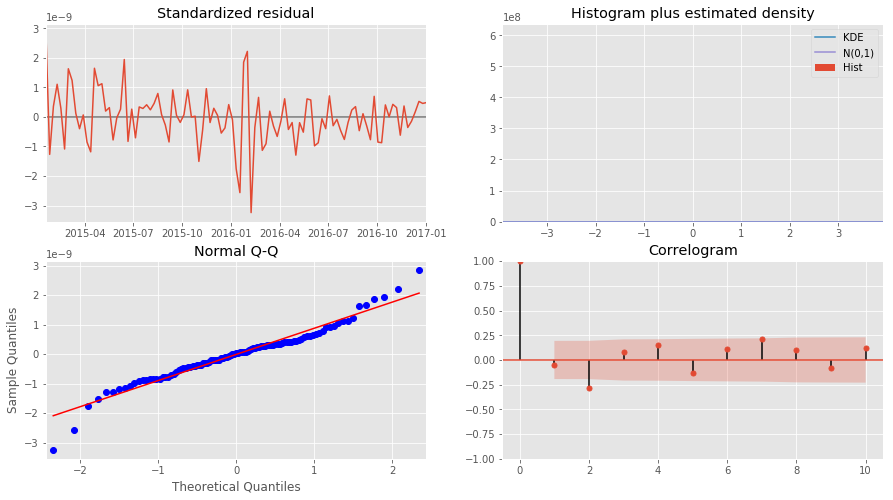

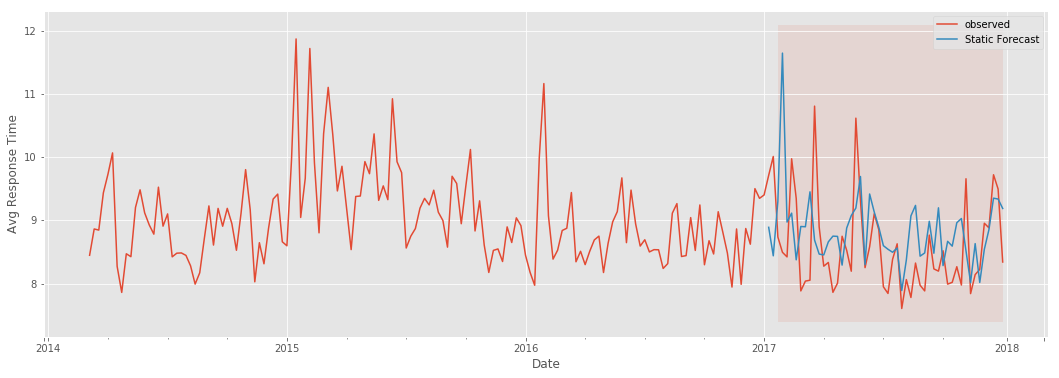

The MSE when guessing the mean is 0.8538647759892165
The RMSE when guessing the mean is 0.9240480377064909
The MSE for this model is 0.7611358766202243
The RMSE for this model is 0.8724310153933228
Our model does 5.59% better than guessing the mean call volume!


In [214]:
avg_time_by_borough('BROOKLYN')

The call volume model results for BROOKLYN are below
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp          26.5777         -0       -inf      0.000      26.578      26.578
total_precip     -11.0421         -0        inf      0.000     -11.042     -11.042
total_snowfall     7.6678   7.98e-36   9.61e+35      0.000       7.668       7.668
total_holidays   143.7677   1.13e-35   1.28e+37      0.000     143.768     143.768
ar.L1              0.8782   2.08e-34   4.23e+33      0.000       0.878       0.878
ma.L1             -0.3998    1.1e-33  -3.62e+32      0.000      -0.400      -0.400
ma.S.L52        1.454e+15   2.44e-34   5.96e+48      0.000    1.45e+15    1.45e+15
sigma2          3.082e-13   1.87e-10      0.002      0.999   -3.66e-10    3.67e-10


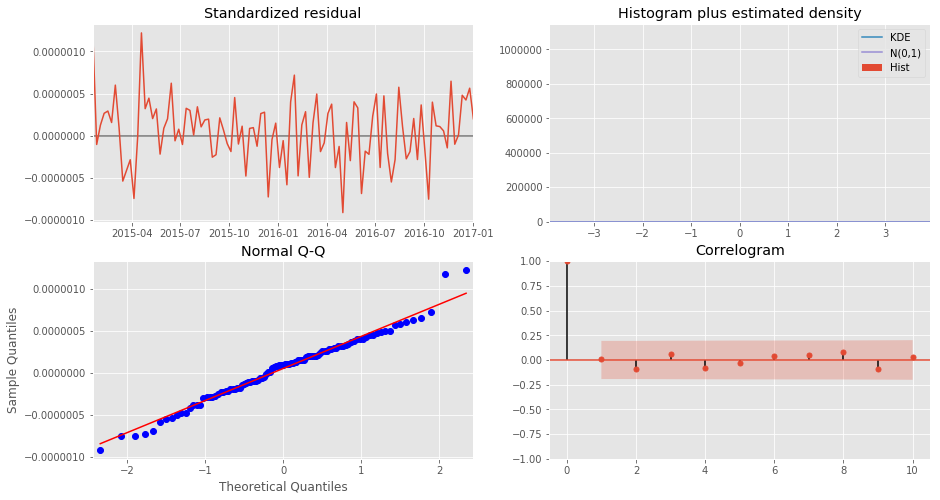

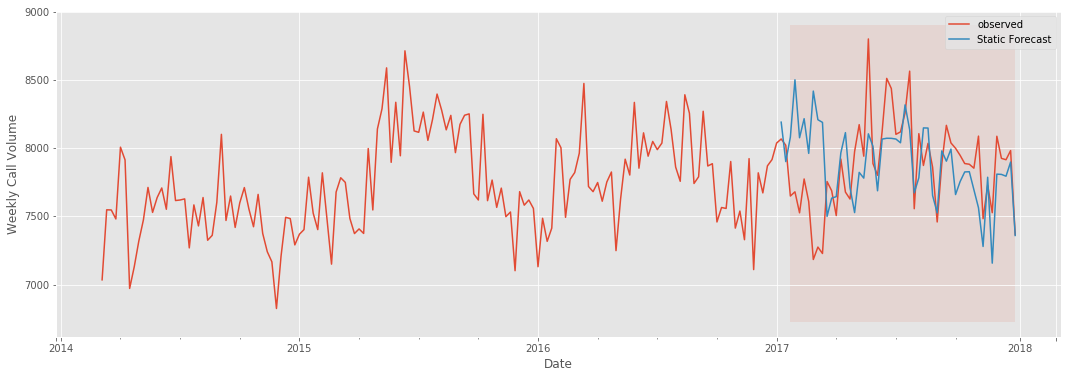

The MSE when guessing the mean is 178070.20814321667
The RMSE when guessing the mean is 421.98365862106164
The MSE for this model is 145875.47215934185
The RMSE for this model is 381.93647660225105
Our model does 9.49% better than guessing the mean call volume!


In [215]:
volume_by_borough('BROOKLYN')

###### Queens

The average response time model results for QUEENS are below
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp           0.0073         -0       -inf      0.000       0.007       0.007
total_precip       0.1179         -0       -inf      0.000       0.118       0.118
total_snowfall     0.1258   9.24e-37   1.36e+35      0.000       0.126       0.126
total_holidays    -0.0603   3.16e-39  -1.91e+37      0.000      -0.060      -0.060
ar.L1              0.0288   1.39e-35   2.07e+33      0.000       0.029       0.029
ma.L1              0.2046   9.53e-36   2.15e+34      0.000       0.205       0.205
ma.S.L52        4.358e+13   8.31e-33   5.24e+45      0.000    4.36e+13    4.36e+13
sigma2            2.5e-11   1.89e-10      0.132      0.895   -3.45e-10    3.95e-10


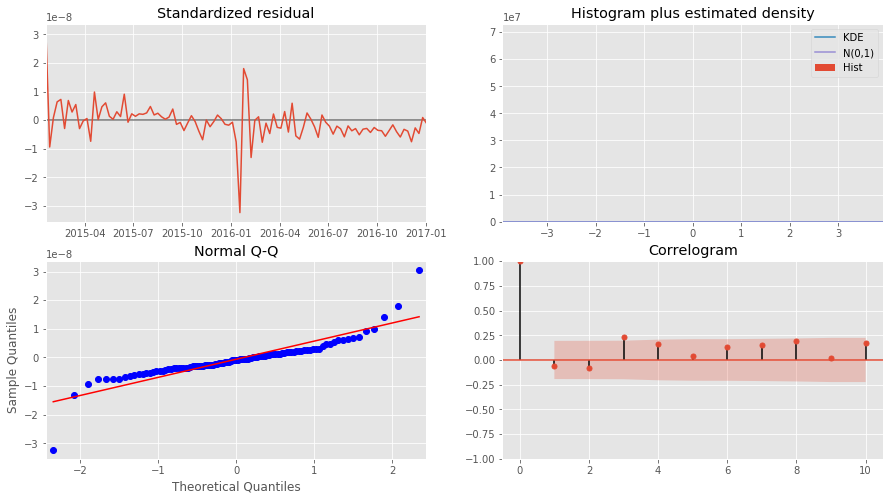

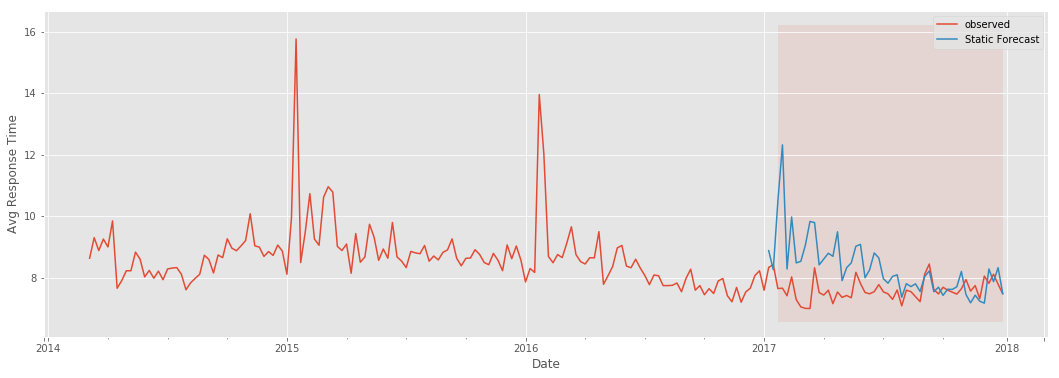

The MSE when guessing the mean is 1.2518346942073224
The RMSE when guessing the mean is 1.1188541880903526
The MSE for this model is 1.4302775663860732
The RMSE for this model is 1.195942125015284
Our model does -6.89% better than guessing the mean call volume!


In [216]:
avg_time_by_borough('QUEENS')

The call volume model results for QUEENS are below
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp          13.3369         -0       -inf      0.000      13.337      13.337
total_precip      -3.7125         -0        inf      0.000      -3.713      -3.713
total_snowfall     7.6848   1.74e-35   4.42e+35      0.000       7.685       7.685
total_holidays    18.1709   5.83e-36   3.12e+36      0.000      18.171      18.171
ar.L1              0.9824   7.15e-33   1.37e+32      0.000       0.982       0.982
ma.L1             -0.6660   6.37e-33  -1.05e+32      0.000      -0.666      -0.666
ma.S.L52       -3.922e+14   9.07e-34  -4.32e+47      0.000   -3.92e+14   -3.92e+14
sigma2          3.783e-12   1.87e-10      0.020      0.984   -3.63e-10    3.71e-10


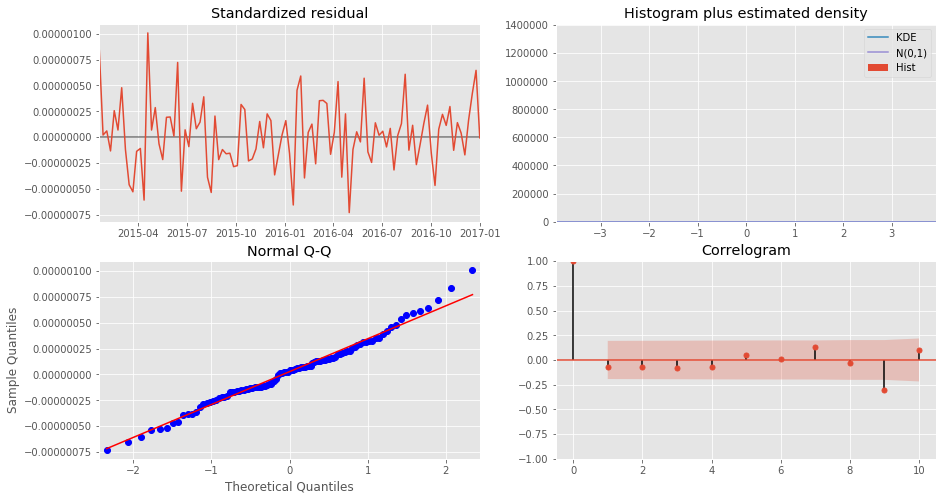

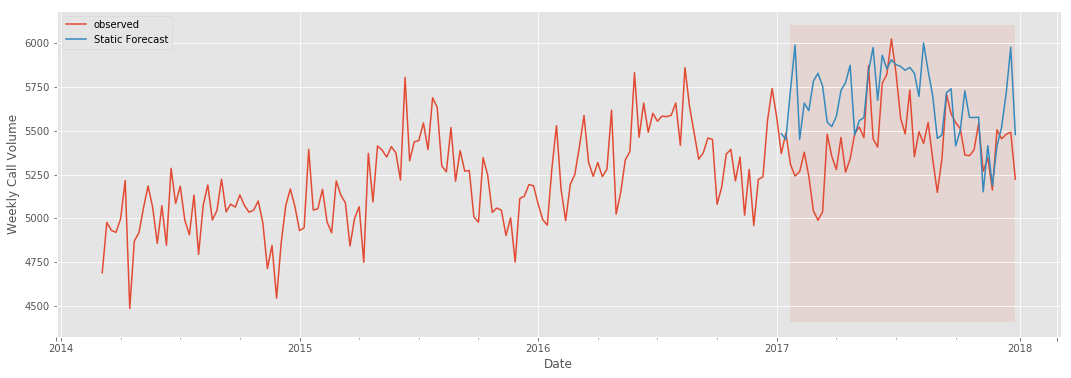

The MSE when guessing the mean is 167618.75480229937
The RMSE when guessing the mean is 409.41269496963497
The MSE for this model is 110304.51651808541
The RMSE for this model is 332.1212376799855
Our model does 18.88% better than guessing the mean call volume!


In [217]:
volume_by_borough('QUEENS')

###### Manhattan

The average response time model results for MANHATTAN are below
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp           0.0560         -0       -inf      0.000       0.056       0.056
total_precip       0.1474         -0       -inf      0.000       0.147       0.147
total_snowfall     0.0606   5.22e-38   1.16e+36      0.000       0.061       0.061
total_holidays    -0.3013   1.54e-38  -1.96e+37      0.000      -0.301      -0.301
ar.L1              0.8257   2.05e-37   4.02e+36      0.000       0.826       0.826
ma.L1             -0.3252   4.96e-35  -6.56e+33      0.000      -0.325      -0.325
ma.S.L52       -2.242e+14   1.62e-33  -1.38e+47      0.000   -2.24e+14   -2.24e+14
sigma2          2.911e-11   1.89e-10      0.154      0.878   -3.42e-10       4e-10


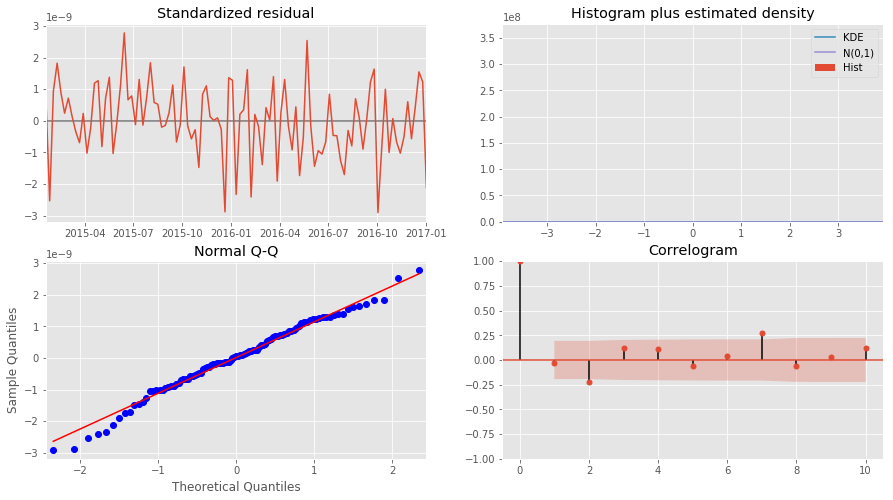

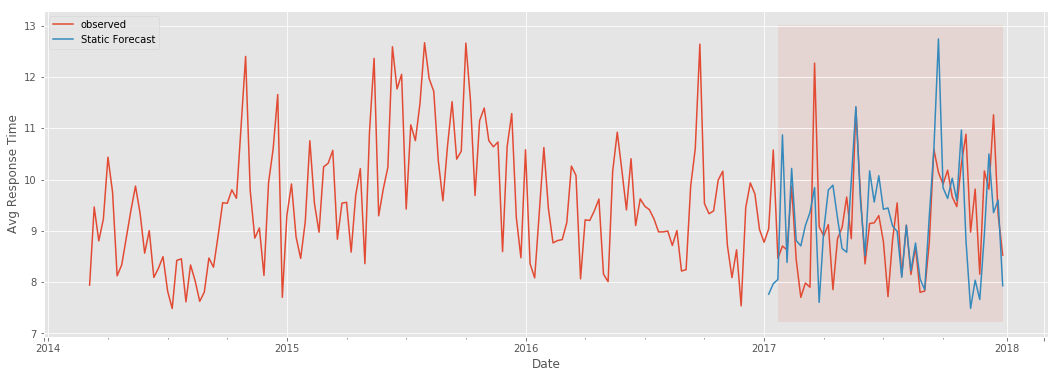

The MSE when guessing the mean is 1.1560429696216685
The RMSE when guessing the mean is 1.0751943869001868
The MSE for this model is 1.2118331556414772
The RMSE for this model is 1.1008329372077659
Our model does -2.38% better than guessing the mean call volume!


In [218]:
avg_time_by_borough('MANHATTAN')

The call volume model results for MANHATTAN are below
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp          23.5745         -0       -inf      0.000      23.575      23.575
total_precip     -20.3250         -0        inf      0.000     -20.325     -20.325
total_snowfall    13.0388   9.64e-36   1.35e+36      0.000      13.039      13.039
total_holidays   -46.6851   3.85e-36  -1.21e+37      0.000     -46.685     -46.685
ar.L1              0.9497   5.88e-34   1.61e+33      0.000       0.950       0.950
ma.L1             -0.4459   1.58e-34  -2.82e+33      0.000      -0.446      -0.446
ma.S.L52        8.819e+13   7.67e-33   1.15e+46      0.000    8.82e+13    8.82e+13
sigma2          6.899e-10   2.58e-10      2.672      0.008    1.84e-10     1.2e-09


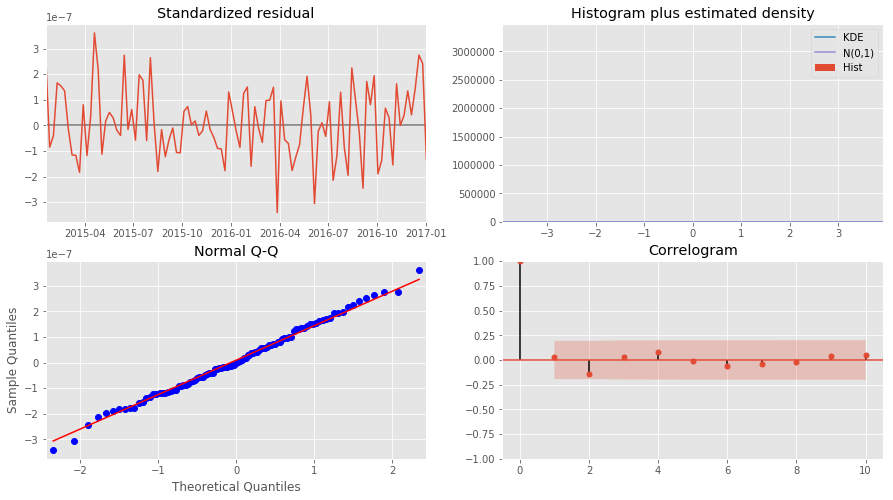

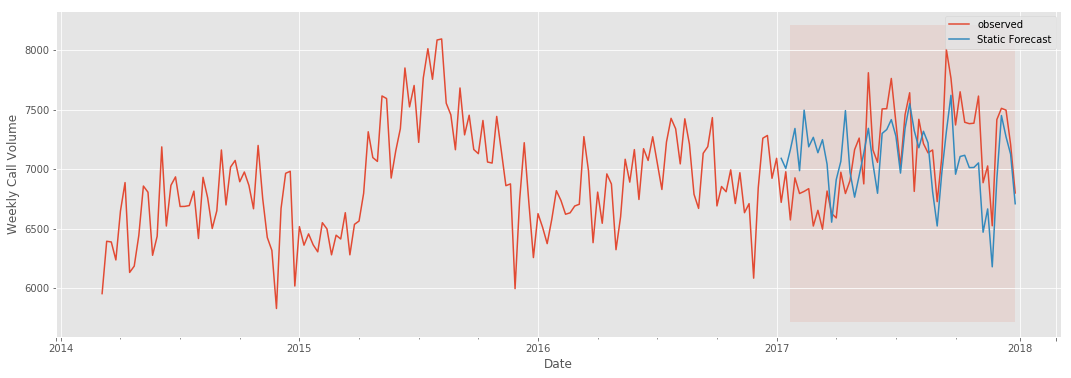

The MSE when guessing the mean is 348517.5426501228
The RMSE when guessing the mean is 590.3537436572439
The MSE for this model is 135381.2236840951
The RMSE for this model is 367.9418754152551
Our model does 37.67% better than guessing the mean call volume!


In [219]:
volume_by_borough('MANHATTAN')

###### Staten Island

The average response time model results for RICHMOND / STATEN ISLAND are below
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp          -0.0334        nan        nan        nan         nan         nan
total_precip       0.0730         -0       -inf      0.000       0.073       0.073
total_snowfall     0.0331   6.43e-39   5.14e+36      0.000       0.033       0.033
total_holidays    -0.0099   3.34e-40  -2.97e+37      0.000      -0.010      -0.010
ar.L1              1.0830   2.11e-36   5.13e+35      0.000       1.083       1.083
ma.L1             -0.9292   6.29e-35  -1.48e+34      0.000      -0.929      -0.929
ma.S.L52       -1.599e+15   2.23e-34  -7.18e+48      0.000    -1.6e+15    -1.6e+15
sigma2          4.789e-12   1.87e-10      0.026      0.980   -3.62e-10    3.72e-10


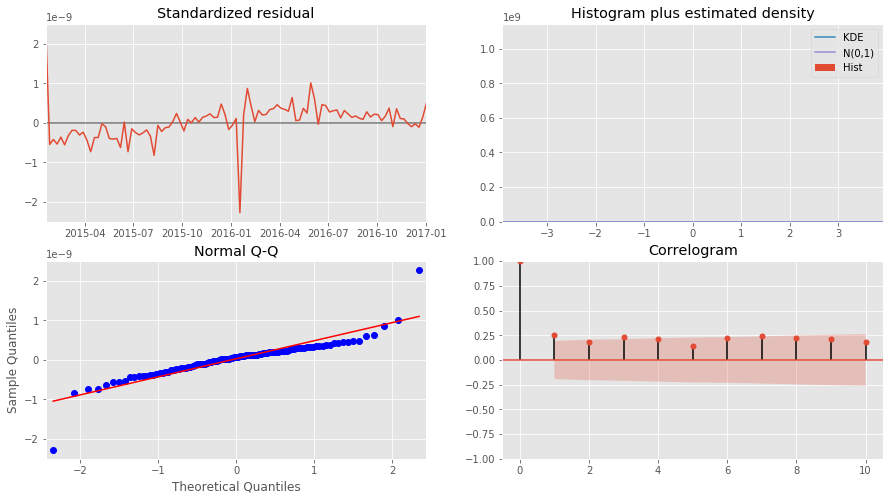

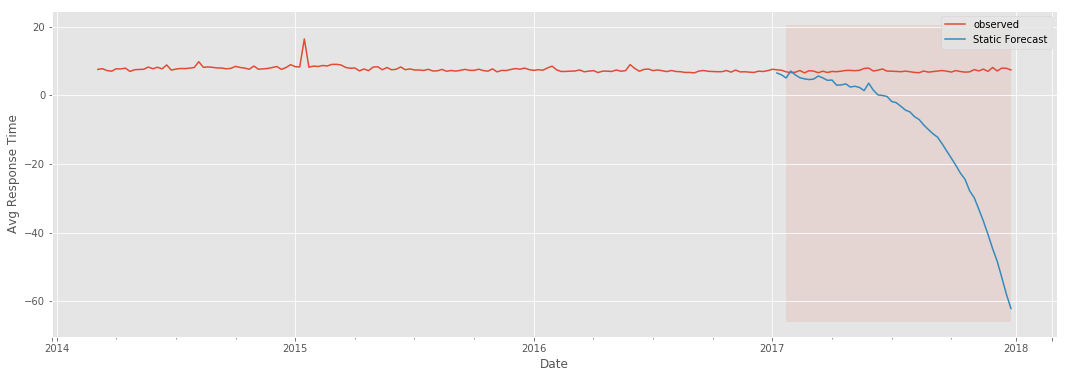

The MSE when guessing the mean is 0.3897402736668357
The RMSE when guessing the mean is 0.6242918177157504
The MSE for this model is 653.2306282063278
The RMSE for this model is 25.55837686955742
Our model does -3993.98% better than guessing the mean call volume!


In [220]:
avg_time_by_borough('RICHMOND / STATEN ISLAND')

The call volume model results for RICHMOND / STATEN ISLAND are below
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp           2.7544         -0       -inf      0.000       2.754       2.754
total_precip      -2.6459         -0        inf      0.000      -2.646      -2.646
total_snowfall     1.1854   7.29e-35   1.63e+34      0.000       1.185       1.185
total_holidays    17.6238    8.6e-36   2.05e+36      0.000      17.624      17.624
ar.L1              0.6996   1.64e-33   4.27e+32      0.000       0.700       0.700
ma.L1             -0.3898   2.01e-33  -1.94e+32      0.000      -0.390      -0.390
ma.S.L52       -5.175e+14   6.85e-34  -7.55e+47      0.000   -5.18e+14   -5.18e+14
sigma2           1.65e-13   1.87e-10      0.001      0.999   -3.66e-10    3.67e-10


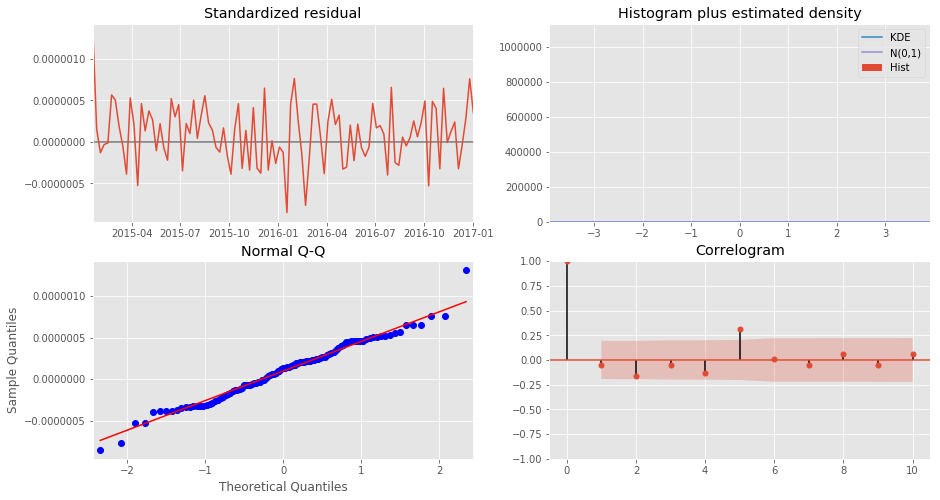

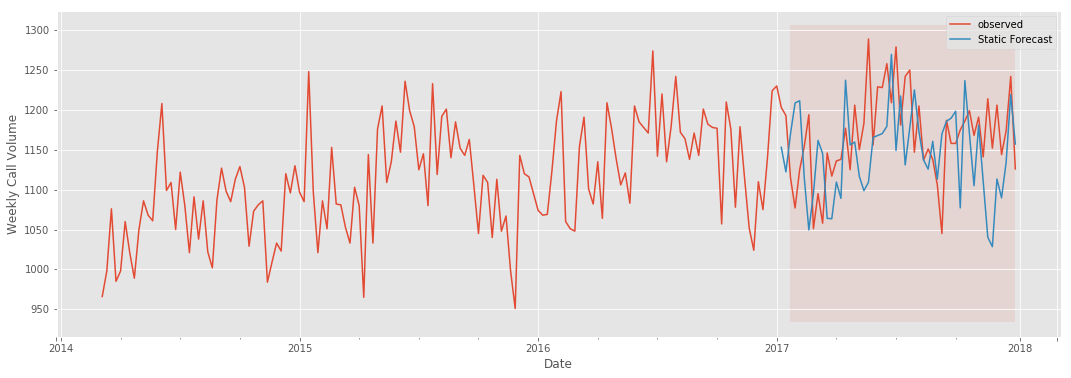

The MSE when guessing the mean is 9064.089340903378
The RMSE when guessing the mean is 95.20551108472334
The MSE for this model is 5557.784752297386
The RMSE for this model is 74.55055165655976
Our model does 21.7% better than guessing the mean call volume!


In [221]:
volume_by_borough('RICHMOND / STATEN ISLAND')